In [25]:
from data_loader import OpenImagesDataset, collate_fn
from params import DEVICE, CPU_DEVICE
from non_max_surpression import NonMaxSurpression
from model import DogDetectorModel
from model_transformations import Transformations
from mean_average_precision import MAP
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np
import copy

In [26]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [27]:
# Initializing the model
model = DogDetectorModel()

# Moving to training device
model = model.to(DEVICE)

In [28]:
checkpoint = torch.load('model_2.pt')
model.load_state_dict(checkpoint['model_state_dict'])
maps = checkpoint['MAPs']
model = model.eval()

In [29]:
epochs = [i[0] for i in maps]
maps = [i[1].item() for i in maps]

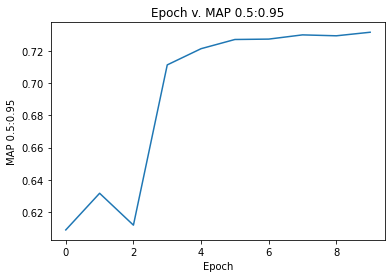

In [30]:
plt.plot(epochs, maps)
plt.title("Epoch v. MAP 0.5:0.95")
plt.xlabel('Epoch')
plt.ylabel('MAP 0.5:0.95')
plt.show()

## Determining optimum NMS Cutoffs

In [31]:
# Reading in the training data
validationData = OpenImagesDataset(rootDirectory='open-images-v6',
                                 transform=Transformations, 
                                 dataType='test')    

# Defining the training data
validationDataLoader = DataLoader(dataset=validationData, 
                             batch_size=1,
                             num_workers=1,
                             shuffle=False, collate_fn=collate_fn)

In [32]:
outputsAll = []
targetsAll = []

# Turning off the gradient
with torch.no_grad():
    for (images, targets) in validationDataLoader:
        # Moving everything to training device
        images = list(image.to(DEVICE) for image in images)

        outputs = model(images, targets)

        outputs = [{k: v.to(CPU_DEVICE) for k, v in t.items()} for t in outputs]

        outputsAll += (outputs)
        targetsAll += (targets)

/home/aidan/Programs/miniconda3/envs/dogapp/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [47]:
nms = NonMaxSurpression(0.5, 0.75)

outputsAllSurpressed = nms(copy.deepcopy(outputsAll))

In [48]:
APs = []
for threshold in torch.arange(start=0.5, end=1, step=0.05):
    APs.append(MAP(outputsAllSurpressed, copy.deepcopy(targetsAll), threshold))
map = sum(APs)/len(APs)

In [49]:
map

tensor(0.7381)

In [24]:
results = np.zeros((19,19))

for i in range(1, 20):
    for j in range(1,20):
        print(i, j)
        probThreshold=0.05 * i
        iouThreshold=0.05 * j
        
        nms = NonMaxSurpression(probThreshold, iouThreshold)
                
        outputsAllSurpressed = nms(copy.deepcopy(outputsAll))
        
        APs = []
        for threshold in torch.arange(start=0.5, end=1, step=0.05):
            APs.append(MAP(outputsAllSurpressed, copy.deepcopy(targetsAll), threshold))
            
        map = sum(APs)/len(APs)
        
        results[i-1,j-1] = map

        
        
        


1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
11 16
11 17
11 18
11 19
12 1
12 2
12 3
1

In [25]:
with open('map_grid.npy', 'wb') as f:
    np.save(f, results)

In [3]:
results = np.load('map_grid.npy')

In [44]:
[round(i * 0.05,2) for i in list(range(1,20))]

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [ ]:
[0, 0.25,0.5,0.75]

/tmp/ipykernel_905/4269036419.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0.0, 0.05, 0.25,0.5,0.75,1])
/tmp/ipykernel_905/4269036419.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.05, 0.25,0.5,0.75,1])


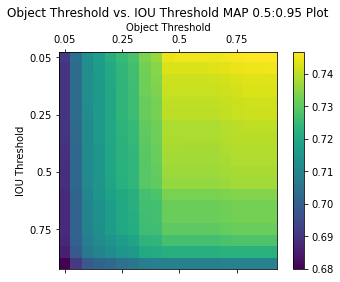

In [40]:
fig, ax = plt.subplots()
ax.matshow(results)
ax.set_xlabel('Object Threshold')
ax.set_ylabel('IOU Threshold')
ax.xaxis.set_label_position('top') 
ax.set_xticklabels([0.0, 0.05, 0.25,0.5,0.75,1])
ax.set_yticklabels([0.0, 0.05, 0.25,0.5,0.75,1])
plt.title('Object Threshold vs. IOU Threshold MAP 0.5:0.95 Plot')
img = ax.matshow(results, interpolation='none')
plt.colorbar(img, ax=ax)
plt.show()

In [17]:
np.where(results == results.max())

(array([0]), array([18]))

In [15]:
results[0,18]

0.7467242479324341

In [50]:
# Reading in the training data
testData = OpenImagesDataset(rootDirectory='open-images-v6',
                                 transform=Transformations, 
                                 dataType='test')    

# Defining the training data
testDataLoader = DataLoader(dataset=testData, 
                             batch_size=1,
                             num_workers=2,
                             shuffle=False, collate_fn=collate_fn)

In [51]:
outputsAll = []
targetsAll = []

# Turning off the gradient
with torch.no_grad():
    for (images, targets) in validationDataLoader:
        # Moving everything to training device
        images = list(image.to(DEVICE) for image in images)

        outputs = model(images, targets)

        outputs = [{k: v.to(CPU_DEVICE) for k, v in t.items()} for t in outputs]

        outputsAll += (outputs)
        targetsAll += (targets)

In [52]:
nms = NonMaxSurpression(0.5, 0.75)

outputsAllSurpressed = nms(copy.deepcopy(outputsAll))

In [53]:
APs = []
for threshold in torch.arange(start=0.5, end=1, step=0.05):
    APs.append(MAP(outputsAllSurpressed, copy.deepcopy(targetsAll), threshold))
map = sum(APs)/len(APs)

In [54]:
map

tensor(0.7381)